# Preparation of dataset

In [1]:
import tpot
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform
import pandas as pd
import matplotlib.pyplot as plt
import chemparse
from matplotlib.patches import Rectangle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import LeaveOneOut
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.svm import SVR
import matplotlib
from sklearn.decomposition import PCA
import pandas as pd
import chemparse
import os

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-12.6-arm64-arm-64bit
Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
Pandas 1.4.2
Scikit-Learn 1.0.2
GPU is available


In [2]:
descriptor = pd.read_csv(r'output.csv', header = None, sep = "\s+|\t+|\s+\t+|\t+\s+", engine='python')
desc_only = descriptor.iloc[:, 1:-1] ## properties_A, X_A, properties_B, X_B (16 each), where X_A weighted are properties of elements

# original order in the output.csv file:
#                A1       B1      A1/B1             A1*B1     
# ionic radii   1.035  0.8525 1.2140762463343107  0.8823375 
# idbond         2.2     2.0      1.1                4.4
# electronegativity 2.02 1.83 1.1038251366120218 3.6966
# vwd            2.07 2.04 1.0147058823529411 4.222799999999999
# ion E          7.285516 17.9024681 0.9219291881735024 57.5735577820396
# molar V          21.31 7.09        3.005641748942172 151.0879
# atomic number    83.0 26.0 3.1923076923076925 2158.0
# atomic mass    208.9804  55.845 3.742150595397977 11670.510438 

In [152]:
descriptor.iloc[:, 0:1]

,0
0,(Bi100.0)(Ca100.0)(Fe100.0)()X3
1,(Bi95.0)(Ca5.0)(Fe100.0)()X3
2,(Bi90.0)(Ca10.0)(Fe100.0)()X3
3,(Bi85.0)(Ca15.0)(Fe100.0)()X3
4,(Bi80.0)(Ca20.0)(Fe100.0)()X3
...,...
80,(Ca200.0)()(Fe100.0)(Bi100.0)X3
81,(Ca200.0)()(Sm100.0)(Bi100.0)X3
82,(Ca200.0)()(Dy100.0)(Bi100.0)X3
83,(Ca200.0)()(Fe100.0)(Bi100.0)X3


Text(0.5, 1.0, '        A1     A2    B1     B2    A1/B1 A2/B2 A1*B1 A2*B2')

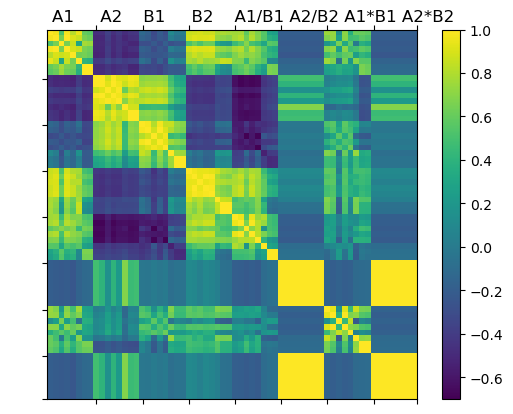

In [3]:
# Just for visualization - legacy code
# rearranged into: A1   A2    B1  B2  A1/B1   A2/B2  A1*B1  A2*B2
desc_only_rearranged = desc_only[[1,  5,  9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, #A1 A2
                                  2,  6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, #B1 B2
                                  3,  7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, # A1/B1 A2/B2
                                  4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64]] # A1*B1 A2*B2

figure = plt.figure()
axes = figure.add_subplot(111)

caxes = axes.matshow(desc_only_rearranged.corr())
figure.colorbar(caxes)

ticks = [8, 16, 24, 32, 40, 48, 56, 63.5]
axes.set_xticks(ticks)
axes.set_yticks(ticks)
axes.set_xticklabels(['' , '' , '' , '' , '' , '' , '' , '' , ])
axes.set_yticklabels(['' , '' , '' , '' , '' , '' , '' , '' , ])
axes.set_title('        A1     A2    B1     B2    A1/B1 A2/B2 A1*B1 A2*B2')

In [4]:
# naming the columns in the desc_only dataframe
counter = 0

for properties in ("'ionic_radii_", "'ideal_X-O_bond_", "'electronegativity_", "'vdW_radius_",
                   "'ionization_E_", "'Molar_V_", "'Atomic_#_", "'Atomic_mass_"):
    for site in ('A1', 'B1', 'A1/B1', 'A1*B1'):
        counter = counter + 1
#        print (str(counter)+': '+properties+site+"',")
    
for properties in ("'ionic_radii_", "'ideal_X-O_bond_", "'electronegativity_", "'vdW_radius_",
                   "'ionization_E_", "'Molar_V_", "'Atomic_#_", "'Atomic_mass_"):
    for site in ('A2', 'B2', 'A2/B2', 'A2*B2'):
        counter = counter + 1
#        print (str(counter)+': '+properties+site+"',")

In [5]:
desc_only_named = desc_only.rename({
1: 'ionic_radii_A1', 2: 'ionic_radii_B1',  3: 'ionic_radii_A1/B1',  4: 'ionic_radii_A1*B1', 5: 'ideal_X-O_bond_A1',
6: 'ideal_X-O_bond_B1', 7: 'ideal_X-O_bond_A1/B1',  8: 'ideal_X-O_bond_A1*B1',  9: 'electronegativity_A1',
10: 'electronegativity_B1', 11: 'electronegativity_A1/B1', 12: 'electronegativity_A1*B1',
13: 'vdW_radius_A1', 14: 'vdW_radius_B1', 15: 'vdW_radius_A1/B1', 16: 'vdW_radius_A1*B1',
17: 'ionization_E_A1', 18: 'ionization_E_B1', 19: 'ionization_E_A1/B1', 20: 'ionization_E_A1*B1',
21: 'Molar_V_A1', 22: 'Molar_V_B1', 23: 'Molar_V_A1/B1', 24: 'Molar_V_A1*B1', 25: 'Atomic_#_A1', 26: 'Atomic_#_B1',
27: 'Atomic_#_A1/B1', 28: 'Atomic_#_A1*B1', 29: 'Atomic_mass_A1',  30: 'Atomic_mass_B1', 31: 'Atomic_mass_A1/B1',
32: 'Atomic_mass_A1*B1', 33: 'ionic_radii_A2',  34: 'ionic_radii_B2', 35: 'ionic_radii_A2/B2', 36: 'ionic_radii_A2*B2',
37: 'ideal_X-O_bond_A2', 38: 'ideal_X-O_bond_B2', 39: 'ideal_X-O_bond_A2/B2', 40: 'ideal_X-O_bond_A2*B2', 41: 'electronegativity_A2',
42: 'electronegativity_B2', 43: 'electronegativity_A2/B2', 44: 'electronegativity_A2*B2', 45: 'vdW_radius_A2',
46: 'vdW_radius_B2',  47: 'vdW_radius_A2/B2', 48: 'vdW_radius_A2*B2', 49: 'ionization_E_A2', 50: 'ionization_E_B2',
51: 'ionization_E_A2/B2',  52: 'ionization_E_A2*B2', 53: 'Molar_V_A2',  54: 'Molar_V_B2', 55: 'Molar_V_A2/B2',
56: 'Molar_V_A2*B2', 57: 'Atomic_#_A2',  58: 'Atomic_#_B2', 59: 'Atomic_#_A2/B2', 60: 'Atomic_#_A2*B2', 61: 'Atomic_mass_A2',
62: 'Atomic_mass_B2', 63: 'Atomic_mass_A2/B2', 64: 'Atomic_mass_A2*B2',
}, axis=1)

desc_only_named # named dataframe

,ionic_radii_A1,ionic_radii_B1,ionic_radii_A1/B1,ionic_radii_A1*B1,ideal_X-O_bond_A1,ideal_X-O_bond_B1,ideal_X-O_bond_A1/B1,ideal_X-O_bond_A1*B1,electronegativity_A1,electronegativity_B1,...,Molar_V_A2/B2,Molar_V_A2*B2,Atomic_#_A2,Atomic_#_B2,Atomic_#_A2/B2,Atomic_#_A2*B2,Atomic_mass_A2,Atomic_mass_B2,Atomic_mass_A2/B2,Atomic_mass_A2*B2
0,1.03500,0.8525,1.214076,0.882337,2.20,2.00,1.100000,4.40,2.020,1.83,...,0.0,0.0,20.0,0.0,0.0,0.0,40.0780,0.0000,0.0,0.0
1,0.98325,0.8525,1.153372,0.838221,2.09,2.00,1.045000,4.18,1.919,1.83,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0039,0.0000,0.0,0.0
2,0.93150,0.8525,1.092669,0.794104,1.98,2.00,0.990000,3.96,1.818,1.83,...,0.0,0.0,2.0,0.0,0.0,0.0,4.0078,0.0000,0.0,0.0
3,0.87975,0.8525,1.031965,0.749987,1.87,2.00,0.935000,3.74,1.717,1.83,...,0.0,0.0,3.0,0.0,0.0,0.0,6.0117,0.0000,0.0,0.0
4,0.82800,0.8525,0.971261,0.705870,1.76,2.00,0.880000,3.52,1.616,1.83,...,0.0,0.0,4.0,0.0,0.0,0.0,8.0156,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,2.28000,0.8525,2.674487,1.943700,4.80,2.00,2.400000,9.60,2.000,1.83,...,0.0,0.0,0.0,83.0,0.0,0.0,0.0000,208.9804,0.0,0.0
81,2.28000,1.2290,1.855167,2.802120,4.80,2.45,1.959184,11.76,2.000,1.17,...,0.0,0.0,0.0,83.0,0.0,0.0,0.0000,208.9804,0.0,0.0
82,2.28000,1.1310,2.015915,2.578680,4.80,2.35,2.042553,11.28,2.000,1.22,...,0.0,0.0,0.0,83.0,0.0,0.0,0.0000,208.9804,0.0,0.0
83,2.28000,0.8525,2.674487,1.943700,4.80,2.00,2.400000,9.60,2.000,1.83,...,0.0,0.0,0.0,83.0,0.0,0.0,0.0000,208.9804,0.0,0.0


In [6]:
# Visual check that the first compund is right:
#                A1       B1      A1/B1             A1*B1     
# ionic radii   1.035  0.8525 1.2140762463343107  0.8823375 
# idbond         2.2     2.0      1.1                4.4
# electronegativity 2.02 1.83 1.1038251366120218 3.6966
# vwd            2.07 2.04 1.0147058823529411 4.222799999999999
# ion E          7.285516 17.9024681 0.9219291881735024 57.5735577820396
# molar V          21.31 7.09        3.005641748942172 151.0879
# atomic number    83.0 26.0 3.1923076923076925 2158.0
# atomic mass    208.9804  55.845 3.742150595397977 11670.510438 

[Text(0, 7.5, ''),
 Text(0, 15.5, ''),
 Text(0, 23.5, ''),
 Text(0, 31.5, ''),
 Text(0, 39.5, ''),
 Text(0, 47.5, ''),
 Text(0, 55.5, ''),
 Text(0, 63.5, '')]

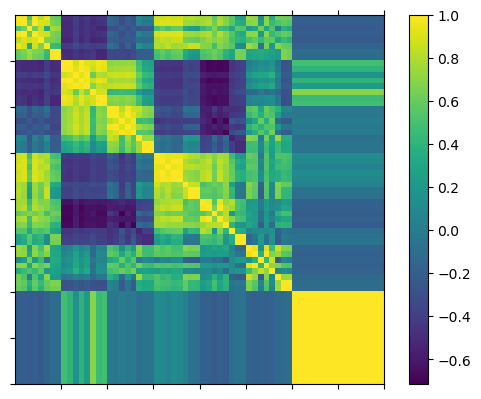

In [7]:
# delete A2/B2 and A2*B2
# graph = desc_only_named.loc[:,~desc_only_named.columns.str.endswith('A2/B2')]
# graph_withoutA2B2_comb = graph.loc[:,~graph.columns.str.endswith('A2*B2')]

# reorder the columns:
one = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_A1')]
two = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_A2')]
three = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_B1')]
four = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_B2')]
five = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_A1/B1')]
six = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_A1*B1')]
seven = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_A2/B2')]
eight = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_A2*B2')]

desc_only_A1A2B1B2A1B1A2B2 = pd.concat([one, two, three, four, five, six, seven, eight], axis=1)


# visualize the correlations of the columns:
figure = plt.figure()
axes = figure.add_subplot(111)

#caxes = axes.matshow(matrix_plt[~desc_only_A1A2B1B2divProd.duplicated()].corr())
caxes = axes.matshow(desc_only_A1A2B1B2A1B1A2B2[~desc_only_A1A2B1B2A1B1A2B2.duplicated()].corr())
figure.colorbar(caxes)

ticks = [7.5, 15.5, 23.5, 31.5, 39.5, 47.5, 55.5, 63.5]
axes.set_xticks(ticks)
axes.set_yticks(ticks)
axes.set_xticklabels(['' , '' , '' , '' , '' , '', '' , ''])
axes.set_yticklabels(['' , '' , '' , '' , '' , '', '' , ''])

In [8]:
desc_only_A1A2B1B2A1B1A2B2 # it is the same as desc_only_rearranged just named, 64 columns

,ionic_radii_A1,ideal_X-O_bond_A1,electronegativity_A1,vdW_radius_A1,ionization_E_A1,Molar_V_A1,Atomic_#_A1,Atomic_mass_A1,ionic_radii_A2,ideal_X-O_bond_A2,...,Atomic_#_A2/B2,Atomic_mass_A2/B2,ionic_radii_A2*B2,ideal_X-O_bond_A2*B2,electronegativity_A2*B2,vdW_radius_A2*B2,ionization_E_A2*B2,Molar_V_A2*B2,Atomic_#_A2*B2,Atomic_mass_A2*B2
0,1.03500,2.20,2.020,2.0700,7.285516,21.3100,83.00,208.98040,1.140,2.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.98325,2.09,1.919,1.9665,6.921240,20.2445,78.85,198.53138,0.057,0.12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.93150,1.98,1.818,1.8630,6.556964,19.1790,74.70,188.08236,0.114,0.24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.87975,1.87,1.717,1.7595,6.192689,18.1135,70.55,177.63334,0.171,0.36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.82800,1.76,1.616,1.6560,5.828413,17.0480,66.40,167.18432,0.228,0.48,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,2.28000,4.80,2.000,4.6200,12.226311,52.4000,40.00,80.15600,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,2.28000,4.80,2.000,4.6200,12.226311,52.4000,40.00,80.15600,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,2.28000,4.80,2.000,4.6200,12.226311,52.4000,40.00,80.15600,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,2.28000,4.80,2.000,4.6200,12.226311,52.4000,40.00,80.15600,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Simple correlation matrix plot for A1 features:

In [9]:
#pd.plotting.scatter_matrix(desc_only.iloc[:, [0, 4, 8, 12, 16, 20, 24, 28]], alpha=0.2, figsize=(8, 8))

Histograms showing the zero features:

array([[<AxesSubplot: title={'center': '1'}>,
        <AxesSubplot: title={'center': '2'}>,
        <AxesSubplot: title={'center': '3'}>,
        <AxesSubplot: title={'center': '4'}>],
       [<AxesSubplot: title={'center': '5'}>,
        <AxesSubplot: title={'center': '6'}>,
        <AxesSubplot: title={'center': '7'}>,
        <AxesSubplot: title={'center': '8'}>],
       [<AxesSubplot: title={'center': '9'}>,
        <AxesSubplot: title={'center': '10'}>,
        <AxesSubplot: title={'center': '11'}>,
        <AxesSubplot: title={'center': '12'}>],
       [<AxesSubplot: title={'center': '13'}>,
        <AxesSubplot: title={'center': '14'}>,
        <AxesSubplot: title={'center': '15'}>,
        <AxesSubplot: title={'center': '16'}>],
       [<AxesSubplot: title={'center': '17'}>,
        <AxesSubplot: title={'center': '18'}>,
        <AxesSubplot: title={'center': '19'}>,
        <AxesSubplot: title={'center': '20'}>],
       [<AxesSubplot: title={'center': '21'}>,
        <AxesSubp

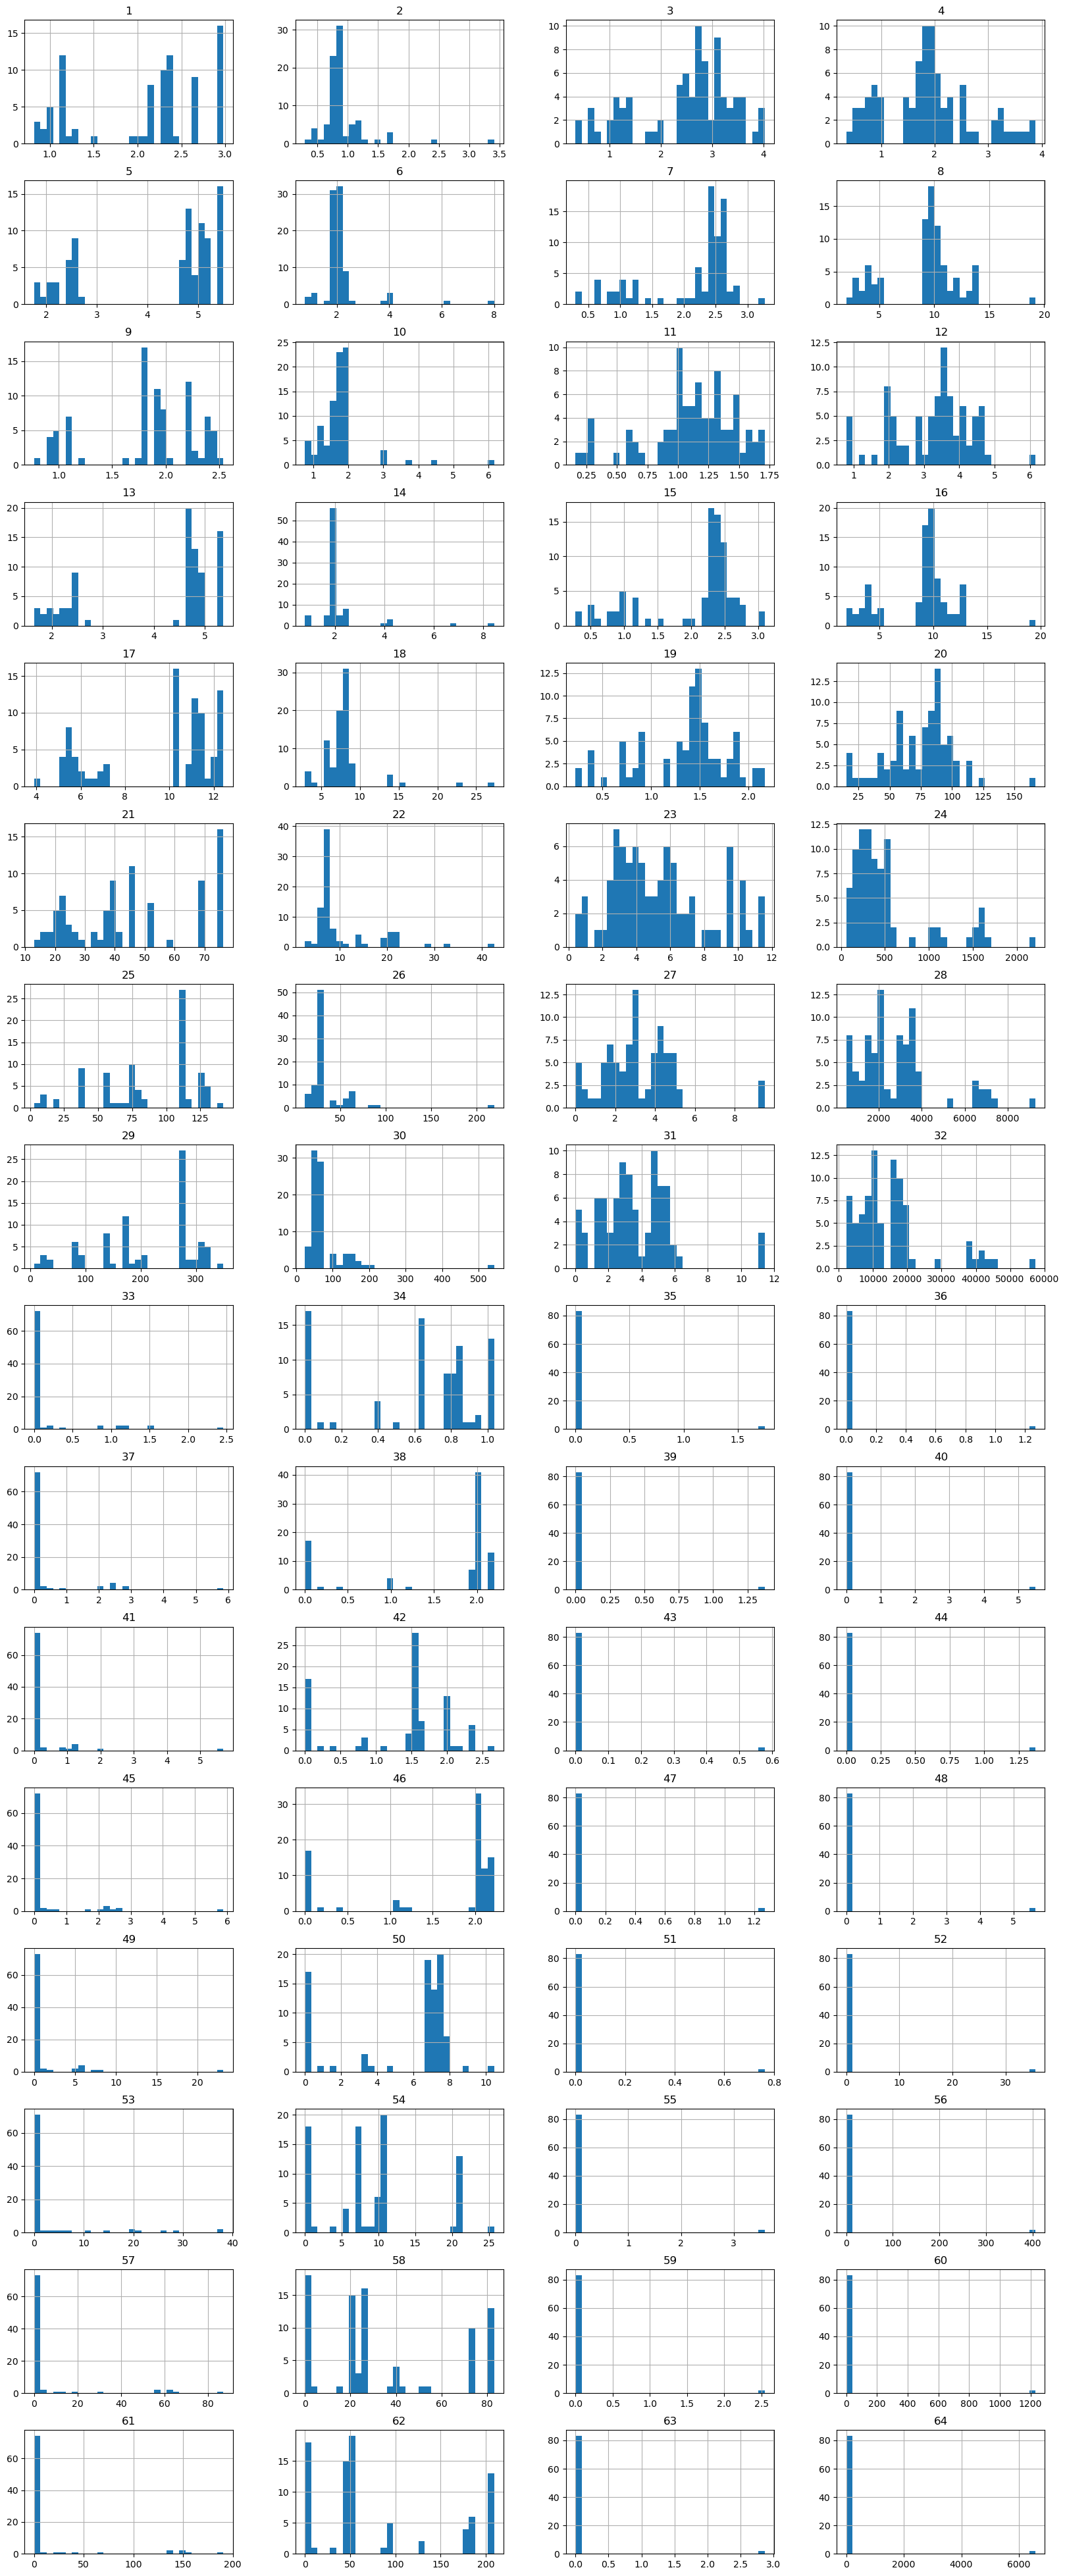

In [35]:
desc_only.hist(figsize = (20, 50), layout = (16, 4), bins=30)

Reading of elemental weight composition:

In [11]:
df = pd.read_excel(r'/Users/hostas/Documents/01-Analysis/2022-11-06 Perovskites/perovskites.xlsx')

cleaned = pd.DataFrame()
cleaned['Chemical Formula']=df['Chemical Formula']
cleaned['Chemical Formula Dictionary']=df['Chemical Formula']
lenght=len(cleaned['Chemical Formula'])

for row in range(lenght):
    cleaned['Chemical Formula Dictionary'][row]= chemparse.parse_formula(cleaned['Chemical Formula'][row])
    
matrix = cleaned['Chemical Formula Dictionary'].apply(pd.Series)
matrix['sum'] = matrix.sum(axis = 1)
wlenght=len(matrix.columns)

for col in range(wlenght):
    matrix.iloc[:, col] = matrix.iloc[:, col] / matrix['sum']
        
compositions = matrix.drop(columns='sum').fillna(0)
non_weight_compositions = compositions.copy()
# non_weight_compositions

#Data for elemental weights, source: https://www.angelo.edu/faculty/kboudrea/periodic/structure_mass.htm
elements = ['O', 'La', 'Ba', 'Fe', 'Bi', 'Sr', 'Ti', 'Mn', 'Ca', 'Ni', 'Gd', 'Co', 'Dy', 'Ta', 'Nb', 'W', 'Zn', 'Eu', 'Pr', 'Sm', 'Mg', 'Cr', 'Na', 'In', 'Cu', 'Lu', 'Tb', 'Y', 'Te', 'Ga', 'Nd', 'Ag', 'Ce', 'V', 'I', 'Mo', 'Sc', 'Al', 'Li']
weights = [15.9994, 138.9055, 137.33, 55.847, 208.9804, 87.62, 47.90, 54.9380, 40.08, 58.70, 157.25, 58.9332, 162.50, 180.9479, 92.9064, 183.85, 65.38, 151.96, 140.9077, 150.4, 24.305, 51.996, 22.98977, 114.82, 63.546, 174.967, 158.9254, 88.9059, 127.60, 69.72, 144.24, 107.868, 140.12, 50.9415, 126.9045, 95.94, 44.9559, 26.98154, 6.941]

elemental_weight = dict(zip(elements, weights))

# Change to weight composition
counter = -1

for col in compositions.columns:
    counter+=1
    element = col
    compositions.iloc[:, counter] = compositions.iloc[:, counter] * elemental_weight[col]

lenght=len(compositions['Bi'])

compositions['sum'] = compositions.sum(axis = 1)
wlenght=len(compositions.columns)

for col in range(wlenght):
    compositions.iloc[:, col] = compositions.iloc[:, col] / compositions['sum']
        
weight_compositions = compositions.drop(columns='sum')


weight_compositions_NaN = weight_compositions.copy()
weight_compositions_NaN['Bandgap'] = df.iloc[:, 21]
weight_compositions_NaN = weight_compositions_NaN.dropna()


non_zero_weights = weight_compositions[weight_compositions > 0].count().sort_values(ascending=False)#.iloc[0:11]

del[[matrix, counter, cleaned, elements, weights]]
# compositions
# weight_compositions
# weight_compositions_NaN
# elemental_weight
# non_zero_weights

Doing some back of an envelope calculations to test if there are no errors 

In [219]:
compositions.iloc[0:1, :]

,Bi,Ca,Fe,O,Gd,Cr,Sr,Ta,Ni,Mo,...,V,Ce,Nd,In,Te,Ga,Tb,Y,Al,sum
0,0.592171,0.113571,0.158249,0.136009,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [220]:
weight_compositions.iloc[0:1, :]

,Bi,Ca,Fe,O,Gd,Cr,Sr,Ta,Ni,Mo,...,Pr,V,Ce,Nd,In,Te,Ga,Tb,Y,Al
0,0.592171,0.113571,0.158249,0.136009,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [225]:
mass_test = 208.9804/2+40.08/2+55.847+15.9994*3
mass_test

228.3754

In [228]:
208.9804/2/mass_test # bi

0.4575370201869378

In [235]:
# [         Bi,       Ca,       Fe,           O,          Gd,  ...]
# [   208.9804,    40.08,   55.847,     15.9994,      157.25, … ]

208.9804/2/(208.9804/2+40.08/2+55.847+15.9994*3) # bi 0.4575370201869378

0.4575370201869378

In [232]:
40.08/2/(208.9804/2+40.08/2+55.847+15.9994*3) # Ca 0.0877502568140001

0.0877502568140001

In [233]:
55.847/(208.9804/2+40.08/2+55.847+15.9994*3) # Fe 0.2445403489167397

0.2445403489167397

In [234]:
15.9994*3/(208.9804/2+40.08/2+55.847+15.9994*3) # O 0.21017237408232234

0.21017237408232234

Just a test with Iron that the reading of bandgap/weight compositions work:

In [12]:
# element=['Fe']; color=['orange']
# plt.hist(weight_compositions[element], color=color, edgecolor='black', bins=int(10/1))
# plt.xlabel('Composition / wt.%'); plt.ylabel('No. compounds')
# plt.title(str(non_zero_weights[element][0])+' compounds with '+str(element[0]))
# plt.ylim([0, 80])
# cmap = plt.get_cmap('jet'); low = cmap(0.5)
# handles = [Rectangle((0,0),1,1, color=color[0], ec="k") for c in element]; labels= element
# plt.legend(handles, labels)

Including Crystal system and Sample prep:

In [13]:
encoder = OneHotEncoder(handle_unknown='ignore'); additional = pd.DataFrame()

additional['Crystal system'] = df['Crystal system'].str.lower().str.strip()
additional['Sample preparation'] = df['Sample preparation'].str.lower().str.strip() # additional['Sample preparation'].unique()
newones = pd.get_dummies(additional['Crystal system'])
newones2 = pd.get_dummies(additional['Sample preparation'])
crystal_and_sample = pd.concat([newones, newones2], axis = 1)

In [14]:
print ('shape of desc_only_A1A2B1B2A1B1A2B2: ', desc_only_A1A2B1B2A1B1A2B2.shape)
print ('shape of crystal_and_sample: ', crystal_and_sample.shape)
print ('shape of weight_compositions: ', weight_compositions.shape)
print ('shape of bandgap vector: ', df.iloc[:, 21].shape)
print ('combining together into master_database and striping duplicates into master_database_wo_duplicates')

shape of desc_only_A1A2B1B2A1B1A2B2:  (85, 64)
shape of crystal_and_sample:  (85, 22)
shape of weight_compositions:  (85, 39)
shape of bandgap vector:  (85,)
combining together into master_database and striping duplicates into master_database_wo_duplicates


In [15]:
#desc_only_A1A2B1B2divProd # descriptor 85 x 48 with column elemental property names
master_database = pd.concat([desc_only_A1A2B1B2A1B1A2B2, crystal_and_sample, weight_compositions], axis=1)
master_database['Bandgap'] = df.iloc[:, 21]

master_database_wo_duplicates = master_database[~desc_only_A1A2B1B2A1B1A2B2.duplicated()].dropna()

master_database_wo_duplicates_std = StandardScaler().fit_transform(master_database_wo_duplicates.iloc[:, :-1])
Bandgap_54x = master_database_wo_duplicates['Bandgap']

In [42]:
print ('shape of master_database_wo_duplicates: ', master_database_wo_duplicates.shape)

shape of master_database_wo_duplicates:  (54, 126)


Calculating non zero weights and plotting compounds with the most abundant elements:

In [76]:
weight_md_wo_dupl = master_database_wo_duplicates.iloc[:, 86:-1]
non_zero_weights_wo_dupls = weight_md_wo_dupl[weight_md_wo_dupl > 0].count().sort_values(ascending=False)
#non_zero_weights_wo_dupls.iloc[0:5]

In [72]:
# element=['Ba']; color=['green']
# element=['Fe']; color=['orange']
# element=['O']; color=['gray']
# element=['Sr']; color=['blue']

# plt.hist(master_database_wo_duplicates[element], color=color, edgecolor='black', bins=int(10/1))
# plt.xlabel('Composition / wt.%'); plt.ylabel('No. compounds')
# plt.title(str(non_zero_weights_wo_dupls[element][0])+' compounds with '+str(element[0]))
# plt.ylim([0, 50])
# cmap = plt.get_cmap('jet'); low = cmap(0.5)
# handles = [Rectangle((0,0),1,1, color=color[0], ec="k") for c in element]; labels= element
# plt.legend(handles, labels)

In [83]:
# plt.hist(master_database_wo_duplicates['Bandgap'], color='pink', edgecolor='black', bins=int(10/1))
# plt.xlabel('Bandgap in [eV]'); plt.ylabel('No. compounds')
# plt.title('Bandgap for 54 compounds')
# plt.ylim([0, 20])

In [87]:
# elements_in_md_dataset=weight_md_wo_dupl[weight_md_wo_dupl > 0].count().sort_values(ascending=False).iloc[1:-9]
# matplotlib.rcParams['font.size'] = 15
# matplotlib.rcParams['figure.dpi'] = 100
# fig = plt.figure(figsize = (10,7))
# elements_in_md_dataset.plot(kind='bar', title='Number of Perovskites')#, yticks=[10, 40, 80])

[Text(0, 7.5, ''),
 Text(0, 15.5, ''),
 Text(0, 23.5, ''),
 Text(0, 31.5, ''),
 Text(0, 39.5, ''),
 Text(0, 47.5, ''),
 Text(0, 55.5, ''),
 Text(0, 63.5, '')]

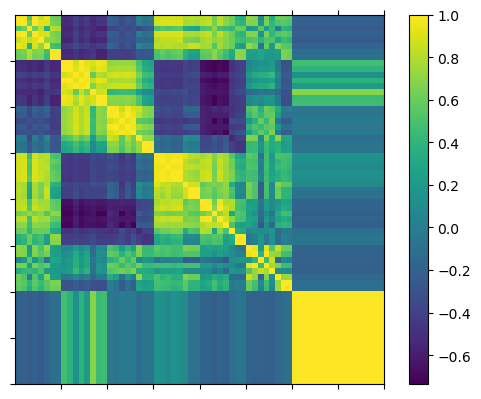

In [18]:
# visualize the correlations of the columns:
figure1 = plt.figure()
axes1 = figure1.add_subplot(111)

caxes = axes1.matshow(master_database_wo_duplicates.iloc[:, 0:64].corr())
figure1.colorbar(caxes)

ticks = [7.5, 15.5, 23.5, 31.5, 39.5, 47.5, 55.5, 63.5]
axes1.set_xticks(ticks)
axes1.set_yticks(ticks)
axes1.set_xticklabels(['' , '' , '', '', '' , '', '' , ''])
axes1.set_yticklabels(['' , '' , '', '', '' , '', '' , ''])

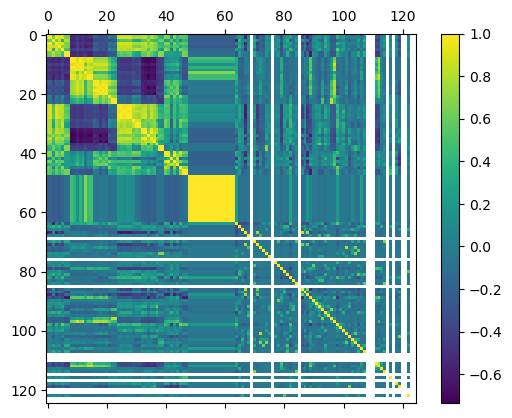

In [30]:
figure2 = plt.figure()
axes2 = figure2.add_subplot(111)

caxes = axes2.matshow(master_database_wo_duplicates.iloc[:, 0:-1].corr())
figure2.colorbar(caxes)

# ticks = [7.5, 15.5, 23.5, 31.5, 39.5, 47.5, 55.5, 63.5]
# axes2.set_xticks(ticks)
# axes2.set_yticks(ticks)
# axes1.set_xticklabels(['' , '' , '', '', '' , '', '' , ''])
# axes1.set_yticklabels(['' , '' , '', '', '' , '', '' , ''])

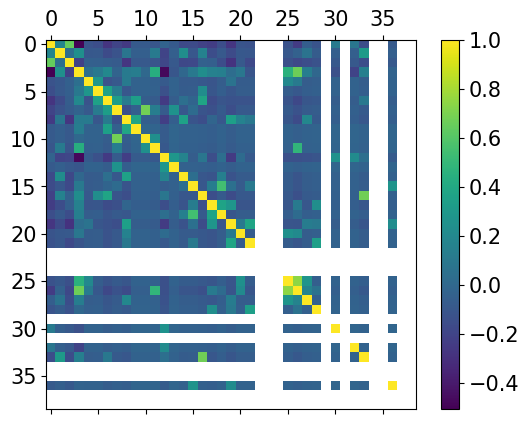

In [170]:
figure2 = plt.figure()
axes2 = figure2.add_subplot(111)

caxes = axes2.matshow(master_database_wo_duplicates.iloc[:, 86:-1].corr())
figure2.colorbar(caxes)

In [174]:
master_database_wo_duplicates.iloc[:, 86:-1].loc[:, (master_database_wo_duplicates.iloc[:, 86:-1] != 0).any(axis=0)].columns

Index(['Bi', 'Ca', 'Fe', 'O', 'Gd', 'Cr', 'Sr', 'Ta', 'Ni', 'Mo', 'Li', 'Cu',
       'Ba', 'Sc', 'W', 'Co', 'Nb', 'La', 'Mg', 'Mn', 'Eu', 'Dy', 'Na', 'Ti',
       'Sm', 'Zn', 'V', 'Nd', 'In', 'Tb'],
      dtype='object')

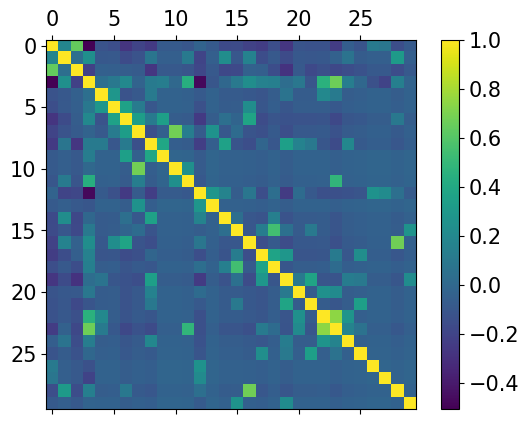

In [175]:
figure2 = plt.figure()
axes2 = figure2.add_subplot(111)

caxes = axes2.matshow(master_database_wo_duplicates.iloc[:, 86:-1].loc[:, (master_database_wo_duplicates.iloc[:, 86:-1] != 0).any(axis=0)].corr())
figure2.colorbar(caxes)